# 1.22c: When and Who? Population Dynamics of Outward Expansion

**Goal:** Understand the temporal and population dynamics of dead token outward expansion.

## The Questions

From 1.22b, we know dead tokens have a strong outward bias (36.9% outward vs 0.3% inward). But:

**WHEN does this expansion happen?**
- All at once (phase transition)?
- Steady drift (continuous expansion)?
- Early burst then plateau?

**TO WHOM does this expansion happen?**
- Democratic: all tokens drift slowly?
- Lottery: only a few tokens move each step?
- Persistent: same tokens keep moving?

## Analyses

1. **Mean radius over time:** Shows when expansion happens
2. **Fraction of movers vs time:** What % of tokens have Δr ≠ 0 at each step?
3. **Distribution of Δr for movers:** Among those who moved, how much?
4. **Persistence:** Do the same tokens keep moving?

## Parameters

In [1]:
# Data paths
FLANNEL_1_PATH = '../tensors/Flannel/1.20a_flannel_1.safetensors'
TOKEN_MASKS_PATH = '../tensors/Flannel/live_dead_tokens.safetensors'

# Visualization
PLOT_DPI = 75
LINEWIDTH = 2
ALPHA = 0.6

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [5]:
print("Loading data...\n")

# Flannel 1
data_1 = load_file(FLANNEL_1_PATH)
W_1 = data_1['embeddings'].to(torch.float32).to(device)

# Token masks
masks = load_file(TOKEN_MASKS_PATH)
dead_mask = masks['dead_mask'].to(device)

n_steps, vocab_size, hidden_dim = W_1.shape
n_dead = dead_mask.sum().item()

print(f"✓ Data loaded")
print(f"  Shape: {W_1.shape}")
print(f"  Dead tokens: {n_dead}")
print(f"  Device: {device}")

Loading data...

✓ Data loaded
  Shape: torch.Size([1001, 10000, 64])
  Dead tokens: 3699
  Device: mps


## Extract Dead Token Embeddings

In [6]:
# Extract dead tokens only
W_dead = W_1[:, dead_mask, :]  # (n_steps, n_dead, hidden_dim)

print(f"\nDead token embeddings:")
print(f"  Shape: {W_dead.shape}")


Dead token embeddings:
  Shape: torch.Size([1001, 3699, 64])


## Compute Radii at Each Timestep

In [7]:
print("\nComputing radii...\n")

# Compute radius for each token at each timestep
radii = torch.norm(W_dead, p=2, dim=2)  # (n_steps, n_dead)

print(f"✓ Computed radii")
print(f"  Shape: {radii.shape}")


Computing radii...

✓ Computed radii
  Shape: torch.Size([1001, 3699])


## WHEN: Mean Radius Over Time

In [8]:
print("\nComputing mean radius over time...\n")

mean_radius = radii.mean(dim=1).cpu().numpy()  # (n_steps,)

print(f"✓ Computed mean radius")
print(f"  Initial (t=0): {mean_radius[0]:.6f}")
print(f"  Final (t={n_steps-1}): {mean_radius[-1]:.6f}")
print(f"  Total change: {mean_radius[-1] - mean_radius[0]:.6f}")


Computing mean radius over time...

✓ Computed mean radius
  Initial (t=0): 0.159323
  Final (t=1000): 0.513296
  Total change: 0.353972



Plotting mean radius over time...



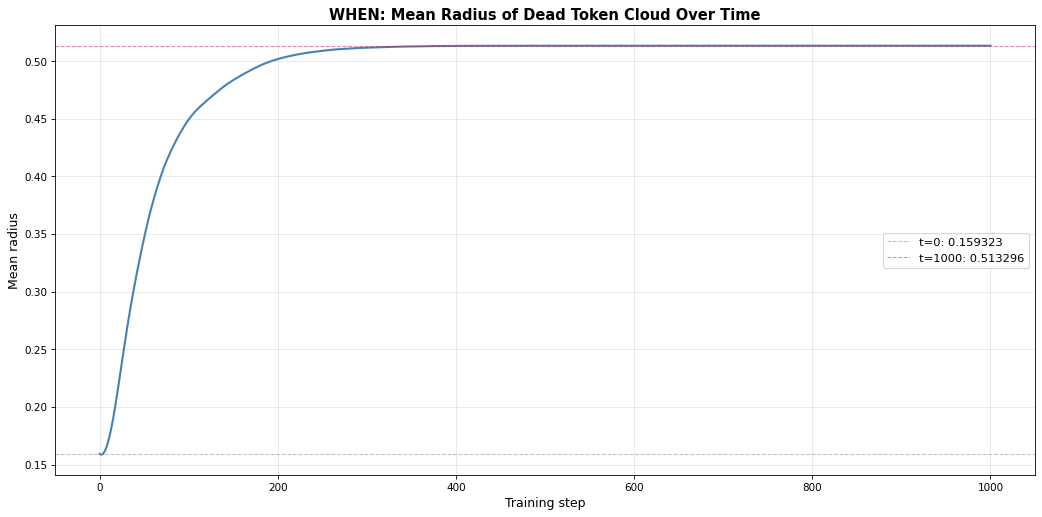

✓ Mean radius plot complete


In [9]:
print("\nPlotting mean radius over time...\n")

fig, ax = plt.subplots(figsize=(14, 7), dpi=PLOT_DPI)

timesteps = np.arange(n_steps)

ax.plot(timesteps, mean_radius, linewidth=LINEWIDTH, color='steelblue')
ax.axhline(mean_radius[0], color='gray', linestyle='--', linewidth=1, alpha=0.5,
           label=f't=0: {mean_radius[0]:.6f}')
ax.axhline(mean_radius[-1], color='crimson', linestyle='--', linewidth=1, alpha=0.5,
           label=f't={n_steps-1}: {mean_radius[-1]:.6f}')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Mean radius', fontsize=12)
ax.set_title('WHEN: Mean Radius of Dead Token Cloud Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
# ax.set_xlim(left=0, right=6)
# ax.set_ylim(top=0.17)

plt.tight_layout()
plt.show()

print("✓ Mean radius plot complete")

## Compute Radial Changes

In [10]:
print("\nComputing radial changes...\n")

# Radial change for each token at each timestep
delta_r = radii[1:] - radii[:-1]  # (n_steps-1, n_dead)

print(f"✓ Computed radial changes")
print(f"  Shape: {delta_r.shape}")


Computing radial changes...

✓ Computed radial changes
  Shape: torch.Size([1000, 3699])


## TO WHOM: Fraction of Movers Over Time

At each timestep, what fraction of tokens have Δr ≠ 0?

In [11]:
print("\nComputing fraction of movers...\n")

# For each timestep, count how many tokens moved
is_outward = (delta_r > 0)  # (n_steps-1, n_dead)
is_inward = (delta_r < 0)
is_stationary = (delta_r == 0)

frac_outward = is_outward.float().mean(dim=1).cpu().numpy()  # (n_steps-1,)
frac_inward = is_inward.float().mean(dim=1).cpu().numpy()
frac_stationary = is_stationary.float().mean(dim=1).cpu().numpy()

print(f"✓ Computed mover fractions")
print(f"  Mean fraction outward: {frac_outward.mean():.4f}")
print(f"  Mean fraction inward: {frac_inward.mean():.4f}")
print(f"  Mean fraction stationary: {frac_stationary.mean():.4f}")


Computing fraction of movers...

✓ Computed mover fractions
  Mean fraction outward: 0.3686
  Mean fraction inward: 0.0033
  Mean fraction stationary: 0.6281



Plotting fraction of movers over time...



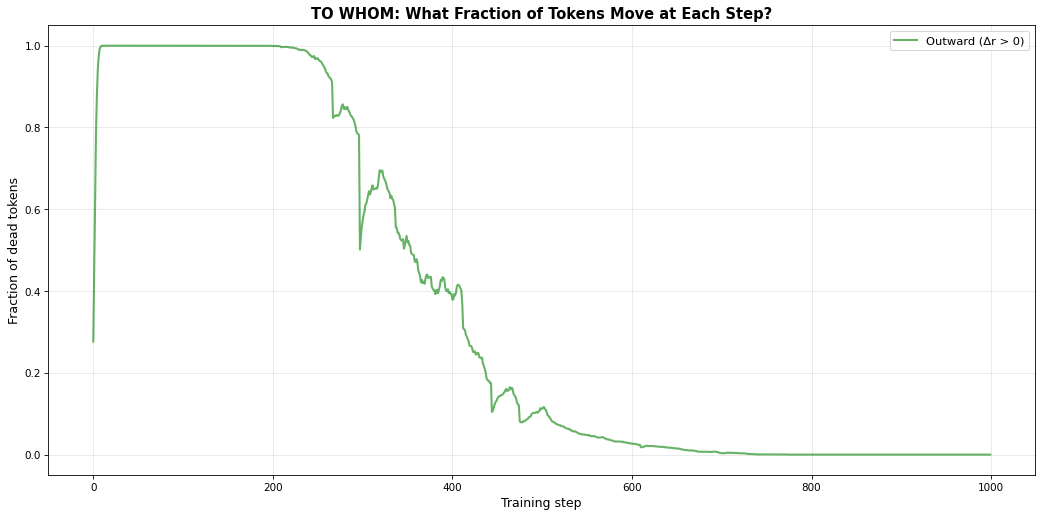

✓ Mover fraction plot complete


In [12]:
print("\nPlotting fraction of movers over time...\n")

fig, ax = plt.subplots(figsize=(14, 7), dpi=PLOT_DPI)

timesteps_delta = np.arange(n_steps - 1)

ax.plot(timesteps_delta, frac_outward, linewidth=LINEWIDTH, color='green', 
        label='Outward (Δr > 0)', alpha=ALPHA)
# ax.plot(timesteps_delta, frac_inward, linewidth=LINEWIDTH, color='crimson', 
#         label='Inward (Δr < 0)', alpha=ALPHA)
# ax.plot(timesteps_delta, frac_stationary, linewidth=LINEWIDTH, color='gray', 
#         label='Stationary (Δr = 0)', alpha=ALPHA)

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Fraction of dead tokens', fontsize=12)
ax.set_title('TO WHOM: What Fraction of Tokens Move at Each Step?', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
# ax.set_xlim(0, n_steps-2)
# ax.set_ylim(0, 1)
# ax.set_xlim(left=-1, right=10)

plt.tight_layout()
plt.show()

print("✓ Mover fraction plot complete")

## Distribution of Δr for Movers

Among tokens that actually moved, how much did they move?

In [13]:
print("\nAnalyzing distribution of Δr for movers...\n")

delta_r_cpu = delta_r.cpu().numpy().flatten()

# Extract only non-zero changes
delta_r_outward = delta_r_cpu[delta_r_cpu > 0]
delta_r_inward = delta_r_cpu[delta_r_cpu < 0]

print(f"Outward movers:")
print(f"  Count: {len(delta_r_outward):,}")
print(f"  Mean: {delta_r_outward.mean():.6e}")
print(f"  Median: {np.median(delta_r_outward):.6e}")
print(f"  Range: [{delta_r_outward.min():.6e}, {delta_r_outward.max():.6e}]")
print()

print(f"Inward movers:")
print(f"  Count: {len(delta_r_inward):,}")
if len(delta_r_inward) > 0:
    print(f"  Mean: {delta_r_inward.mean():.6e}")
    print(f"  Median: {np.median(delta_r_inward):.6e}")
    print(f"  Range: [{delta_r_inward.min():.6e}, {delta_r_inward.max():.6e}]")
else:
    print(f"  (No inward motion detected)")


Analyzing distribution of Δr for movers...

Outward movers:
  Count: 1,363,397
  Mean: 9.643508e-04
  Median: 3.101826e-04
  Range: [2.980232e-08, 6.209090e-03]

Inward movers:
  Count: 12,227
  Mean: -4.456719e-04
  Median: -2.125353e-04
  Range: [-3.731430e-03, -2.980232e-08]



Plotting Δr distribution for movers...



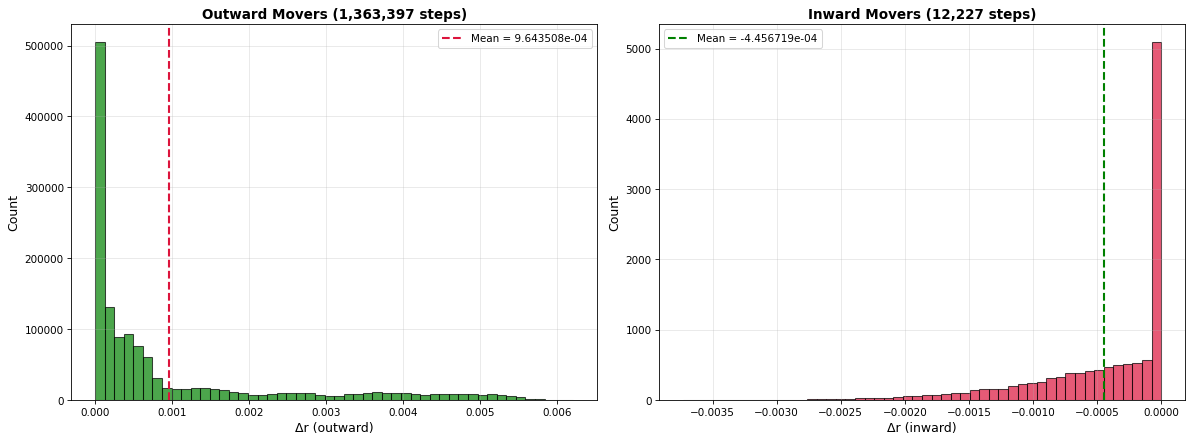

✓ Mover distribution plot complete


In [14]:
print("\nPlotting Δr distribution for movers...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=PLOT_DPI)

# Outward movers
ax1.hist(delta_r_outward, bins=50, color='green', edgecolor='black', alpha=0.7)
ax1.axvline(delta_r_outward.mean(), color='crimson', linestyle='--', linewidth=2,
            label=f'Mean = {delta_r_outward.mean():.6e}')
ax1.set_xlabel('Δr (outward)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Outward Movers ({len(delta_r_outward):,} steps)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Inward movers
if len(delta_r_inward) > 0:
    ax2.hist(delta_r_inward, bins=50, color='crimson', edgecolor='black', alpha=0.7)
    ax2.axvline(delta_r_inward.mean(), color='green', linestyle='--', linewidth=2,
                label=f'Mean = {delta_r_inward.mean():.6e}')
    ax2.set_xlabel('Δr (inward)', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title(f'Inward Movers ({len(delta_r_inward):,} steps)', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
else:
    ax2.text(0.5, 0.5, 'No inward motion detected', 
             ha='center', va='center', fontsize=14, transform=ax2.transAxes)
    ax2.set_title('Inward Movers (0 steps)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Mover distribution plot complete")

## Persistence: Do the Same Tokens Keep Moving?

Compute correlation between consecutive timesteps: if token i moved outward at step t, does it also move outward at step t+1?

In [15]:
print("\nAnalyzing persistence...\n")

# For each token, count how many times it moved outward
outward_counts = is_outward.sum(dim=0).cpu().numpy()  # (n_dead,)

print(f"Outward movement counts per token:")
print(f"  Mean: {outward_counts.mean():.2f} steps (out of {n_steps-1})")
print(f"  Median: {np.median(outward_counts):.0f}")
print(f"  Min: {outward_counts.min()}")
print(f"  Max: {outward_counts.max()}")
print()

# Expected if random (each step has 36.9% chance of outward)
expected_outward = frac_outward.mean() * (n_steps - 1)
print(f"Expected (if random): {expected_outward:.2f} steps per token")
print()

# Compute variance to check if it's Poisson-like
variance = outward_counts.var()
print(f"Variance: {variance:.2f}")
print(f"Expected variance (if Poisson): {expected_outward:.2f}")
print()

if abs(variance - expected_outward) < 0.2 * expected_outward:
    print(f"Interpretation: Poisson-like (random lottery)")
    print(f"  → Each token has equal chance of moving each step")
    print(f"  → No persistent 'hot' or 'cold' tokens")
elif variance > 1.5 * expected_outward:
    print(f"Interpretation: Overdispersed (some tokens move more)")
    print(f"  → Some tokens are 'hot' (move often)")
    print(f"  → Some tokens are 'cold' (rarely move)")
else:
    print(f"Interpretation: Underdispersed (too uniform)")
    print(f"  → Tokens take turns moving")


Analyzing persistence...

Outward movement counts per token:
  Mean: 368.59 steps (out of 1000)
  Median: 353
  Min: 220
  Max: 719

Expected (if random): 368.59 steps per token

Variance: 6882.52
Expected variance (if Poisson): 368.59

Interpretation: Overdispersed (some tokens move more)
  → Some tokens are 'hot' (move often)
  → Some tokens are 'cold' (rarely move)



Plotting persistence distribution...



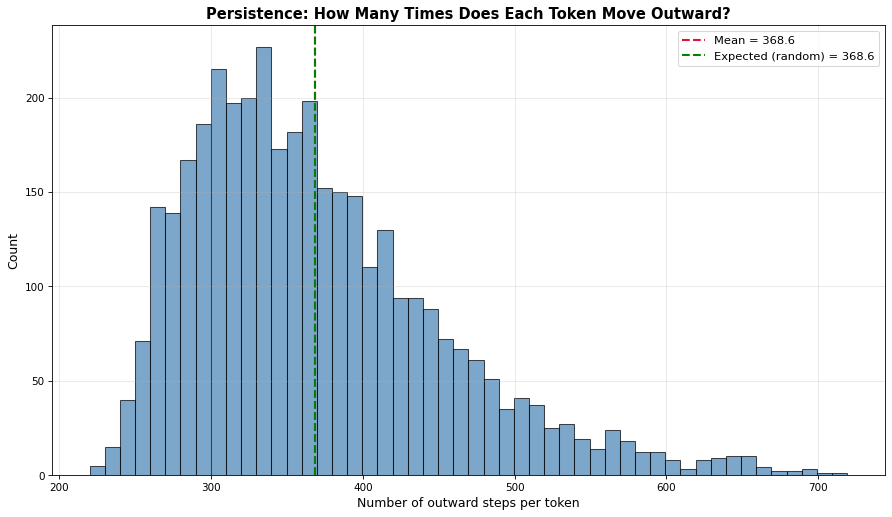

✓ Persistence plot complete


In [16]:
print("\nPlotting persistence distribution...\n")

fig, ax = plt.subplots(figsize=(12, 7), dpi=PLOT_DPI)

ax.hist(outward_counts, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(outward_counts.mean(), color='crimson', linestyle='--', linewidth=2,
           label=f'Mean = {outward_counts.mean():.1f}')
ax.axvline(expected_outward, color='green', linestyle='--', linewidth=2,
           label=f'Expected (random) = {expected_outward:.1f}')

ax.set_xlabel('Number of outward steps per token', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Persistence: How Many Times Does Each Token Move Outward?', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Persistence plot complete")

## Summary

In [17]:
print("\n" + "="*80)
print("SUMMARY: WHEN AND WHO?")
print("="*80 + "\n")

print(f"Dead tokens: {n_dead}")
print(f"Timesteps: {n_steps}")
print()

print(f"WHEN (temporal dynamics):")
print(f"  Initial radius: {mean_radius[0]:.6f}")
print(f"  Final radius: {mean_radius[-1]:.6f}")
print(f"  Total expansion: {mean_radius[-1] - mean_radius[0]:.6f} ({100*(mean_radius[-1]/mean_radius[0] - 1):.1f}%)")
print()

# Characterize expansion shape
expansion_rate_early = mean_radius[100] - mean_radius[0]
expansion_rate_late = mean_radius[-1] - mean_radius[-100]
print(f"  Expansion rate (first 100 steps): {expansion_rate_early:.6f}")
print(f"  Expansion rate (last 100 steps): {expansion_rate_late:.6f}")
if expansion_rate_late < 0.5 * expansion_rate_early:
    print(f"  → Early burst, then slowing (plateau)")
elif expansion_rate_late > 1.5 * expansion_rate_early:
    print(f"  → Accelerating expansion")
else:
    print(f"  → Steady expansion (roughly constant rate)")
print()

print(f"TO WHOM (population dynamics):")
print(f"  Mean fraction outward per step: {frac_outward.mean()*100:.1f}%")
print(f"  Mean fraction inward per step: {frac_inward.mean()*100:.1f}%")
print(f"  Mean fraction stationary per step: {frac_stationary.mean()*100:.1f}%")
print()

print(f"  Outward steps per token: {outward_counts.mean():.1f} (out of {n_steps-1})")
print(f"  Expected if random: {expected_outward:.1f}")
print()

# Overall character
print(f"Character of expansion:")
if frac_outward.mean() > 0.5:
    print(f"  ✓ Majority outward (lottery model)")
    print(f"  → Most tokens move outward when they move at all")
elif frac_outward.mean() > 0.2:
    print(f"  ~ Moderate outward bias (democratic model)")
    print(f"  → Tokens move in various directions, slight outward bias")
else:
    print(f"  ✗ Weak outward motion (mostly stationary)")

if abs(variance - expected_outward) < 0.2 * expected_outward:
    print(f"  ✓ Random lottery (no persistent movers)")
elif variance > 1.5 * expected_outward:
    print(f"  ✓ Persistent movers (some tokens hot, some cold)")

print("\n" + "="*80)


SUMMARY: WHEN AND WHO?

Dead tokens: 3699
Timesteps: 1001

WHEN (temporal dynamics):
  Initial radius: 0.159323
  Final radius: 0.513296
  Total expansion: 0.353972 (222.2%)

  Expansion rate (first 100 steps): 0.290007
  Expansion rate (last 100 steps): 0.000000
  → Early burst, then slowing (plateau)

TO WHOM (population dynamics):
  Mean fraction outward per step: 36.9%
  Mean fraction inward per step: 0.3%
  Mean fraction stationary per step: 62.8%

  Outward steps per token: 368.6 (out of 1000)
  Expected if random: 368.6

Character of expansion:
  ~ Moderate outward bias (democratic model)
  → Tokens move in various directions, slight outward bias
  ✓ Persistent movers (some tokens hot, some cold)

